In [ ]:
from zipfile import ZipFile
import os
os.chdir("/content/sample_data")
print(os.getcwd())
with ZipFile("image_data.zip", 'r') as zip:
    zip.extractall()


/content/sample_data


In [ ]:
import torch
from torchvision import transforms 
import numpy as np
import glob
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

In [ ]:
## transform images using pytorch packages

transformer = transforms.Compose([transforms.Resize((224,224)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [ ]:
train_folder_path = "/content/sample_data/train_data"
test_folder_path = "/content/sample_data/test_data"



In [ ]:
train_folder = torchvision.datasets.ImageFolder(train_folder_path,transform=transformer)
print(len(train_folder))
img_1,label = train_folder[800]           # Load images through imagefolder function and check dimensions
print(img_1.shape,label)



test_folder = torchvision.datasets.ImageFolder(test_folder_path,transform=transformer)
img_2,label = test_folder[2]           # Load images through imagefolder function and check dimensions
print(img_2.shape,label)   
print(train_folder.classes)                                    

900
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
['Benign', 'Malignant']


In [ ]:
img_2


tensor([[[ 0.4510,  0.1843,  0.1922,  ...,  0.0902,  0.0902,  0.4118],
         [-0.1529, -0.7020, -0.6392,  ..., -0.9137, -0.9373, -0.2627],
         [-0.0980, -0.6549, -0.6235,  ..., -0.9294, -0.9373, -0.2471],
         ...,
         [ 0.1529, -0.2706, -0.2314,  ..., -0.5765, -0.6235, -0.0588],
         [ 0.1216, -0.3020, -0.2549,  ..., -0.6000, -0.6392, -0.0980],
         [ 0.5922,  0.3882,  0.4118,  ...,  0.2549,  0.1922,  0.4510]],

        [[ 0.4824,  0.2078,  0.2157,  ...,  0.0902,  0.0980,  0.4196],
         [-0.1294, -0.6863, -0.6235,  ..., -0.9137, -0.9294, -0.2549],
         [-0.0745, -0.6392, -0.6078,  ..., -0.9294, -0.9373, -0.2471],
         ...,
         [ 0.1529, -0.2706, -0.2392,  ..., -0.5765, -0.6235, -0.0588],
         [ 0.1216, -0.3098, -0.2627,  ..., -0.6000, -0.6392, -0.0980],
         [ 0.5922,  0.3882,  0.4118,  ...,  0.2549,  0.1922,  0.4510]],

        [[ 0.4902,  0.2392,  0.2706,  ...,  0.0824,  0.0667,  0.3804],
         [-0.1059, -0.6235, -0.5294,  ..., -0

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def assign_labels(folder):
    for img,label in folder:
        if label == 1:
            label = 0                    # assign class labels Benign = 0 and Malignant = 1 in both test and train data folders
        else:
            label = 1

assign_labels(train_folder)
assign_labels(test_folder)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


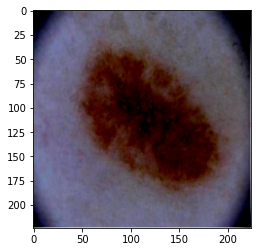

In [ ]:
plt.imshow(img_2.permute(1,2,0))

In [ ]:
total = len(os.listdir( os.path.join(train_folder_path, "Benign"))) + len(os.listdir( os.path.join(train_folder_path, "Malignant")))
class_weights = [ total / len(os.listdir( os.path.join(train_folder_path, "Benign"))), total / len(os.listdir( os.path.join(train_folder_path, "Malignant")))]
val_size = int(0.2 * total);
train_size = total - val_size;

train_data, val_data = random_split(train_folder, [train_size, val_size])

image_weights = [ class_weights[ x[1] ] for x in train_data ]
sampling = WeightedRandomSampler(image_weights, len(train_data))
#train_dataloader = DataLoader(train_folder, batch_size = 100 , sampler=weights#)
train_dataloader = DataLoader(train_data, batch_size = 100, sampler=sampling)
val_dataloader = DataLoader(val_data, batch_size = 100, shuffle=True)
test_dataloader = DataLoader(test_folder, batch_size = 100 , shuffle = True)

In [ ]:
random = iter(train_dataloader)
print(train_dataloader)
img , labels = random.next()
conv1 = nn.Conv2d(3, 16, kernel_size=3,stride = 1  ,padding=1)
print(img.shape)       # original image tensor
x = conv1(img)
print(x.shape)      # conv1 img tensor
pool1 =  nn.MaxPool2d(2, 2)  
x  = pool1(x)
print(x.shape)                                   
conv2 =  nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
x  = conv2(x)
print(x.shape)
x = pool1(x)
print(x.shape)
conv3  =  nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
x = conv3(x)
print(x.shape)
x = pool1(x)
print(x.shape)

torch.Size([100, 3, 224, 224])
torch.Size([100, 16, 224, 224])
torch.Size([100, 16, 112, 112])
torch.Size([100, 32, 112, 112])
torch.Size([100, 32, 56, 56])
torch.Size([100, 64, 56, 56])
torch.Size([100, 64, 28, 28])


In [ ]:
## define a sequential model 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3,out_channels= 8, kernel_size= 3 , stride= 1 ,padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3 , stride =1 , padding = 1 )
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3 , stride =1 , padding = 1 )
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3 , stride =1 , padding = 1 )
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3 , stride =1 , padding = 1 )
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3 , stride =1 , padding = 1 )






        self.fc1 = nn.Linear(256*28*28, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 2)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))


        x = x.view(-1, 256 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = self.fc4(x)
        return x


model = CNN().cuda()

In [ ]:
losses = []
accuracies = []
epoches = 50
start = time.time()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
for epoch in range(epoches):
    epoch_loss = 0
    epoch_accuracy = 0
    for X, y in train_dataloader:
        X = X.cuda()
        y = y.cuda()
        preds = model(X)
        loss = loss_fn(preds, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)
        
    epoch_accuracy = epoch_accuracy/len(train_dataloader)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(epoch_loss)
    print("Epoch: {}, train loss: {:.4f}, train accracy: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))


........Epoch: 0, train loss: 0.7059, train accracy: 0.5200, time: 5.617825031280518
........Epoch: 1, train loss: 0.6948, train accracy: 0.4787, time: 11.059982299804688
........Epoch: 2, train loss: 0.6941, train accracy: 0.4800, time: 16.64521074295044
........Epoch: 3, train loss: 0.6934, train accracy: 0.4813, time: 21.88024663925171
........Epoch: 4, train loss: 0.6932, train accracy: 0.4950, time: 27.16929268836975
........Epoch: 5, train loss: 0.6931, train accracy: 0.5125, time: 32.30161190032959
........Epoch: 6, train loss: 0.6934, train accracy: 0.4950, time: 37.019506216049194
........Epoch: 7, train loss: 0.6921, train accracy: 0.5412, time: 41.71485233306885
........Epoch: 8, train loss: 0.6929, train accracy: 0.5087, time: 46.21132254600525
........Epoch: 9, train loss: 0.6887, train accracy: 0.5187, time: 50.386106729507446
........Epoch: 10, train loss: 0.6719, train accracy: 0.5650, time: 54.55625081062317
........Epoch: 11, train loss: 0.6626, train accracy: 0.5800,

19


In [ ]:
def test():
    # test phase
    model.eval()

    correct = 0
    total_benign = 304
    total_malignent = 75
    num_mal_pred = 0
    num_ben_pred = 0

    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_dataloader:
            # Move the training batch to the GPU
            batch, target = batch.to(device), target.to(device)

            # forward propagation
            output = model(batch)
            print(output.shape)
            # get prediction
            output = torch.argmax(output, 1)
            print(output)
            #print(target)
            # accumulate correct number
            correct += (output == target).sum().item()
            num_mal_pred += output.sum().item()
            num_ben_pred += len(output) - num_mal_pred
            print()

    # Calculate test accuracy, specificity    
    acc = 100 * float(correct) / len(test_folder)
    print('Test accuracy: {}/{} ({:.2f}%)'.format( correct, len(test_folder), acc ) )
    print("True Negative Rate: {}/{} = {:.2f}".format(num_ben_pred, total_benign, num_ben_pred/total_benign))
    print("True Positive Rate: {}/{} = {:.2f}".format(num_mal_pred, total_malignent, num_mal_pred/total_malignent))
    print("Type I Error: {}".format( 1 - (num_mal_pred/total_malignent)))
    print("Type II Error: {}".format( 1 - (num_ben_pred/total_benign)))

test()

tensor([[ 1.5623e+00, -3.4102e+00],
        [ 6.6091e+00, -8.9063e+00],
        [ 7.2169e+00, -1.1639e+01],
        [ 3.5622e+00, -5.1539e+00],
        [-2.7218e+00,  3.1964e+00],
        [ 3.2101e+00, -4.7573e+00],
        [ 7.7965e+00, -1.1562e+01],
        [ 8.9725e+00, -1.3915e+01],
        [-7.1246e+00,  4.4714e+00],
        [-2.1347e+00,  3.1024e-01],
        [-2.1117e+00,  3.1766e+00],
        [ 2.6010e+00, -3.4714e+00],
        [ 6.1019e+00, -9.6371e+00],
        [ 3.1161e+00, -5.1352e+00],
        [ 5.0860e+00, -6.7929e+00],
        [ 4.3887e+00, -7.3391e+00],
        [ 2.9882e+00, -4.3363e+00],
        [ 3.1552e+00, -4.9939e+00],
        [ 5.9971e+00, -8.2743e+00],
        [ 1.1288e+01, -1.6845e+01],
        [ 3.8463e+00, -5.7349e+00],
        [-1.8974e+01,  2.0979e+01],
        [ 7.6013e+00, -1.1402e+01],
        [ 2.0983e+00, -2.9277e+00],
        [ 1.4882e+00, -2.6692e+00],
        [-1.7776e+00,  4.0358e+00],
        [ 6.3825e+00, -8.3556e+00],
        [ 5.4594e+00, -9.497

NameError: ignored

In [ ]:
a = torch.empty(3,5)
a

tensor([[-6.4574e+03,  0.0000e+00,  1.5975e-43,  1.3873e-43,  1.4574e-43],
        [ 6.4460e-44,  1.4153e-43,  1.5274e-43,  1.5695e-43,  1.6255e-43],
        [ 1.6956e-43,  1.5975e-43,  1.7034e+19,  3.3346e+27,  1.1093e+27]])